In [1]:
%load_ext autoreload
%autoreload 2

from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df, create_continuity_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

continuity = create_continuity_df('data/raw/continuity.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
test_caregivers = caregivers.loc[test1_subset]
test_tasks = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]
small_test = (test_caregivers, test_tasks)

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car']
car_tasks = tasks[tasks['PlannedCaregiverID'].isin(car_caregivers.index)]
car_test = (car_caregivers, car_tasks)

full_test = (caregivers, tasks)

In [3]:
from models.fixed_model import FixedModel
from models.tsp_model import TSPModel
model_type = FixedModel
model_caregivers, model_tasks = full_test

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix, continuity)
model.build(
        # caregiver_penalty=0,
        # overtime_penalty=0,
        # worktime_per_break=0,
        # continuity_penalty=0,
)

Set parameter Username
Set parameter LicenseID to value 2635249
Academic license - for non-commercial use only - expires 2026-03-11
Created base variables.
Built base model.
Adding overtime penalties.
Adding caregiver usage penalties.
Adding break requirements with evening shift exemption.
Adding continuity of care penalties.
Updated objective function with penalties.


<gurobi.Model Continuous instance HomeCare: 0 constrs, 0 vars, Parameter changes: Username=(user-defined), LicenseID=2635249>

In [4]:
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 289 rows, 2661 columns and 10053 nonzeros
Model fingerprint: 0x9d6f5619
Model has 3 simple general constraints
  3 INDICATOR
Variable types: 9 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+03]
  Objective range  [8e-01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+02]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [3e-03, 1e+00]
Presolve removed 42 rows and 495 columns
Presolve time: 0.02s
Presolved: 247 rows, 2166 columns, 7598 nonzeros
Variable types: 6 continuous, 2160 integer (2157 binary)
Found heuristic solution: objective 14786.100000

Root relaxation: objective 1.842373e+03, 622 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work

<gurobi.Model MIP instance HomeCare: 289 constrs, 2661 vars, Parameter changes: Username=(user-defined), LicenseID=2635249>

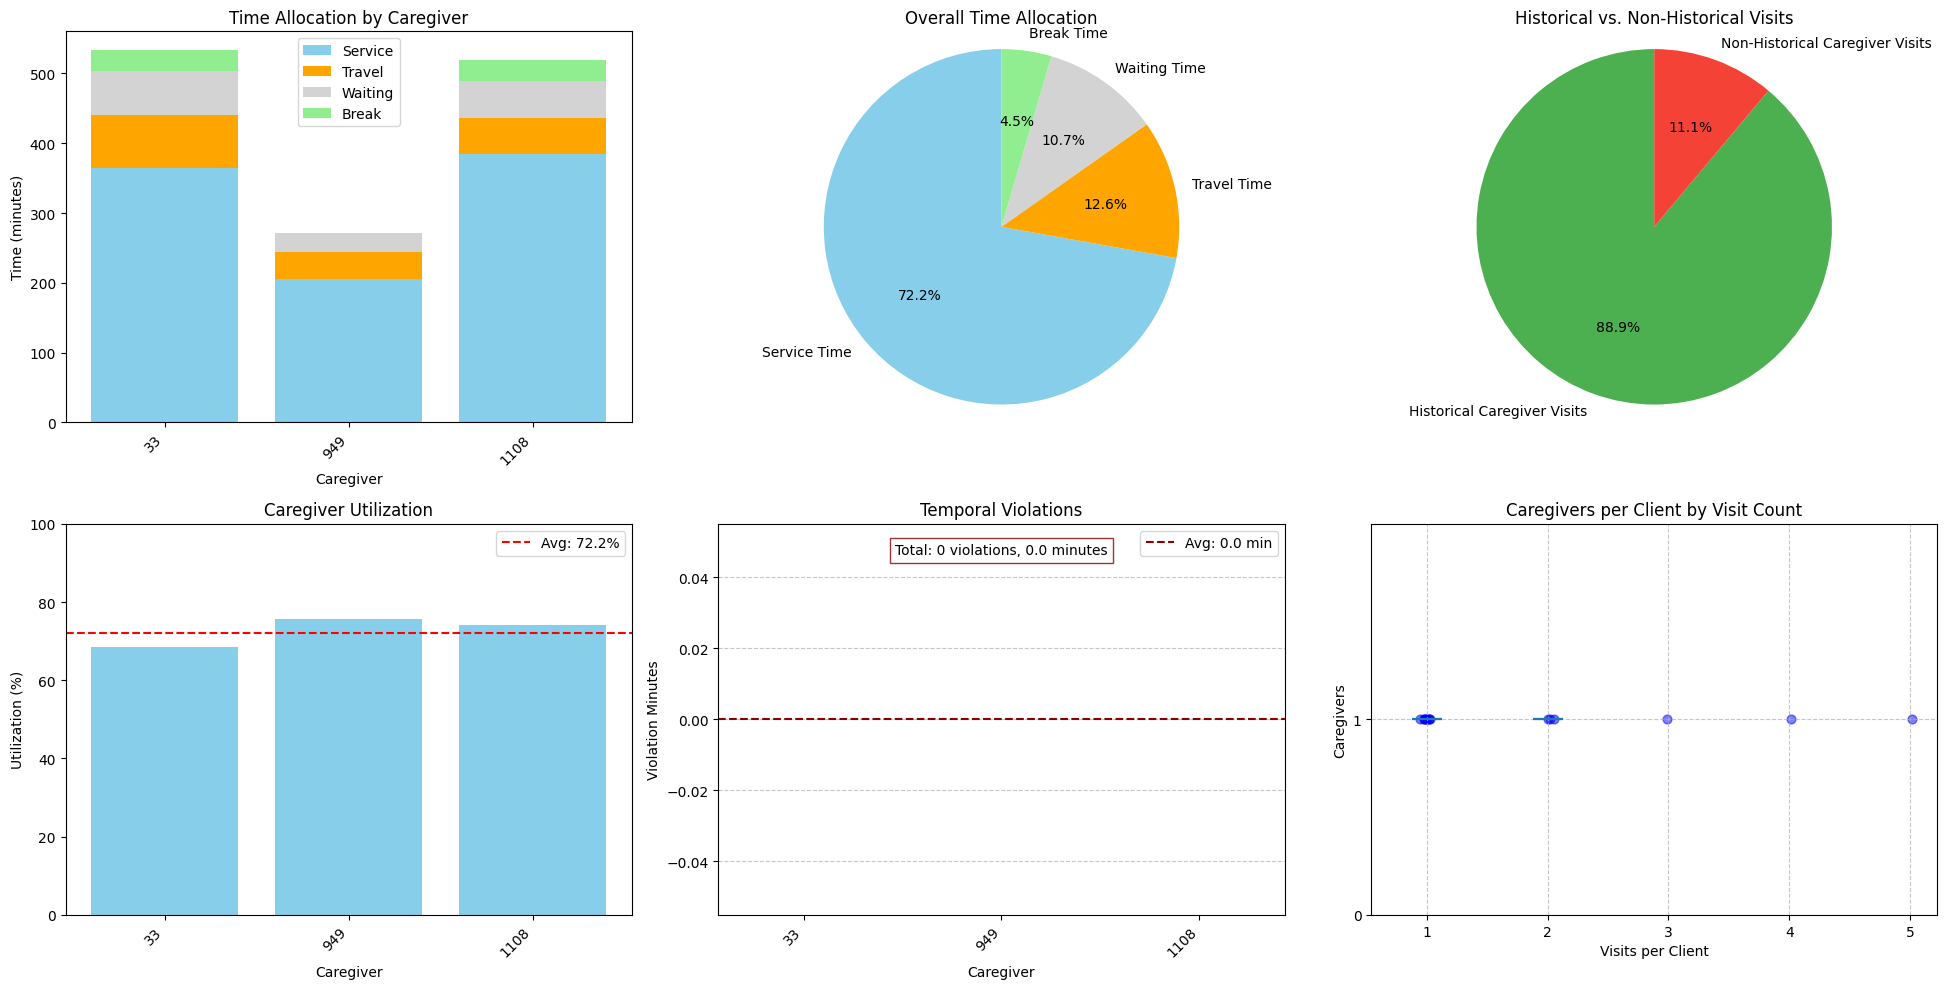

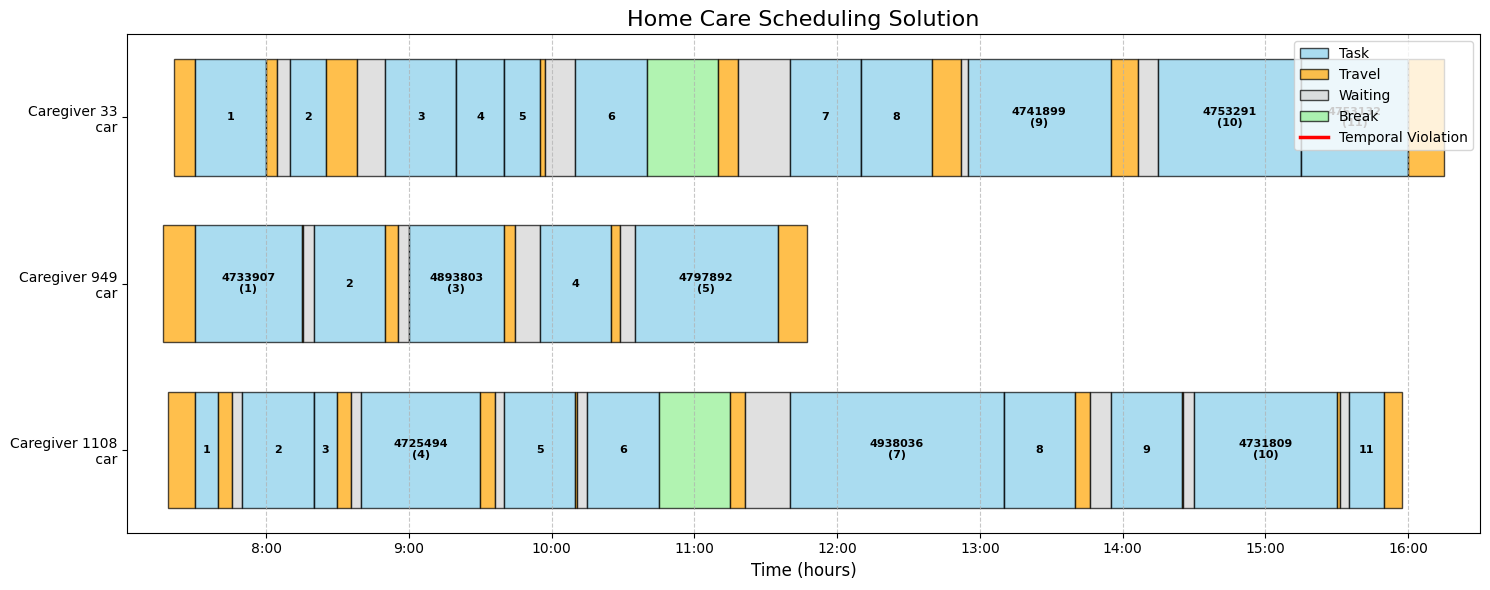

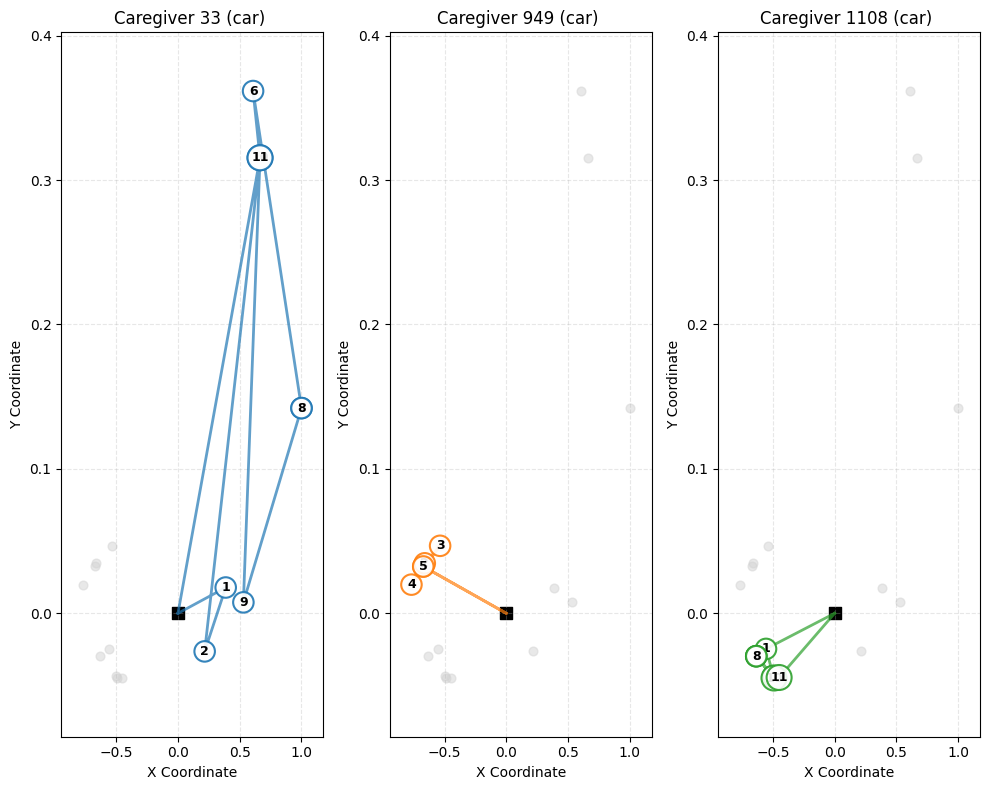

In [5]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes, display_metrics_summary

model.get_solution()

visualize_metrics(model, display_mode='dashboard');
visualize_schedule(model);
visualize_routes(model, caregiver_ids=None, subplot_mode=True);
#display_metrics_summary(model)

In [35]:
from utils.solution_storage import save_solution
save_solution(model, 'full_test_first_draft')

Solution saved to data/saved_solutions/20250331_081731_full_test_first_draft.json


'data/saved_solutions/20250331_081731_full_test_first_draft.json'

  Total time: 917.55, Accounted time: 923.10
  Service: 640.00, Travel: 130.27, Waiting: 152.83, Break: 0.00
  Total time: 406.97, Accounted time: 408.60
  Service: 340.00, Travel: 50.32, Waiting: 18.28, Break: 0.00
  Total time: 917.55, Accounted time: 923.10
  Service: 640.00, Travel: 130.27, Waiting: 152.83, Break: 0.00
  Total time: 406.97, Accounted time: 408.60
  Service: 340.00, Travel: 50.32, Waiting: 18.28, Break: 0.00


/Users/vilhelmkarlin/Code/KTH/SA120X_KEX/utils/visualization.py:805: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  dashboard_fig.show()


(<Figure size 1000x2266.67 with 18 Axes>,
 (<Figure size 1000x2266.67 with 18 Axes>,
  array([<Axes: title={'center': 'Caregiver 33 (car) '}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 36 (car)  (No Route)'}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 113 (car) '}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 284 (car) '}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 438 (car) '}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 756 (car) '}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 833 (car) '}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 905 (car) '}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
         <Axes: title={'center': 'Caregiver 949 (car) '}, xlabel='

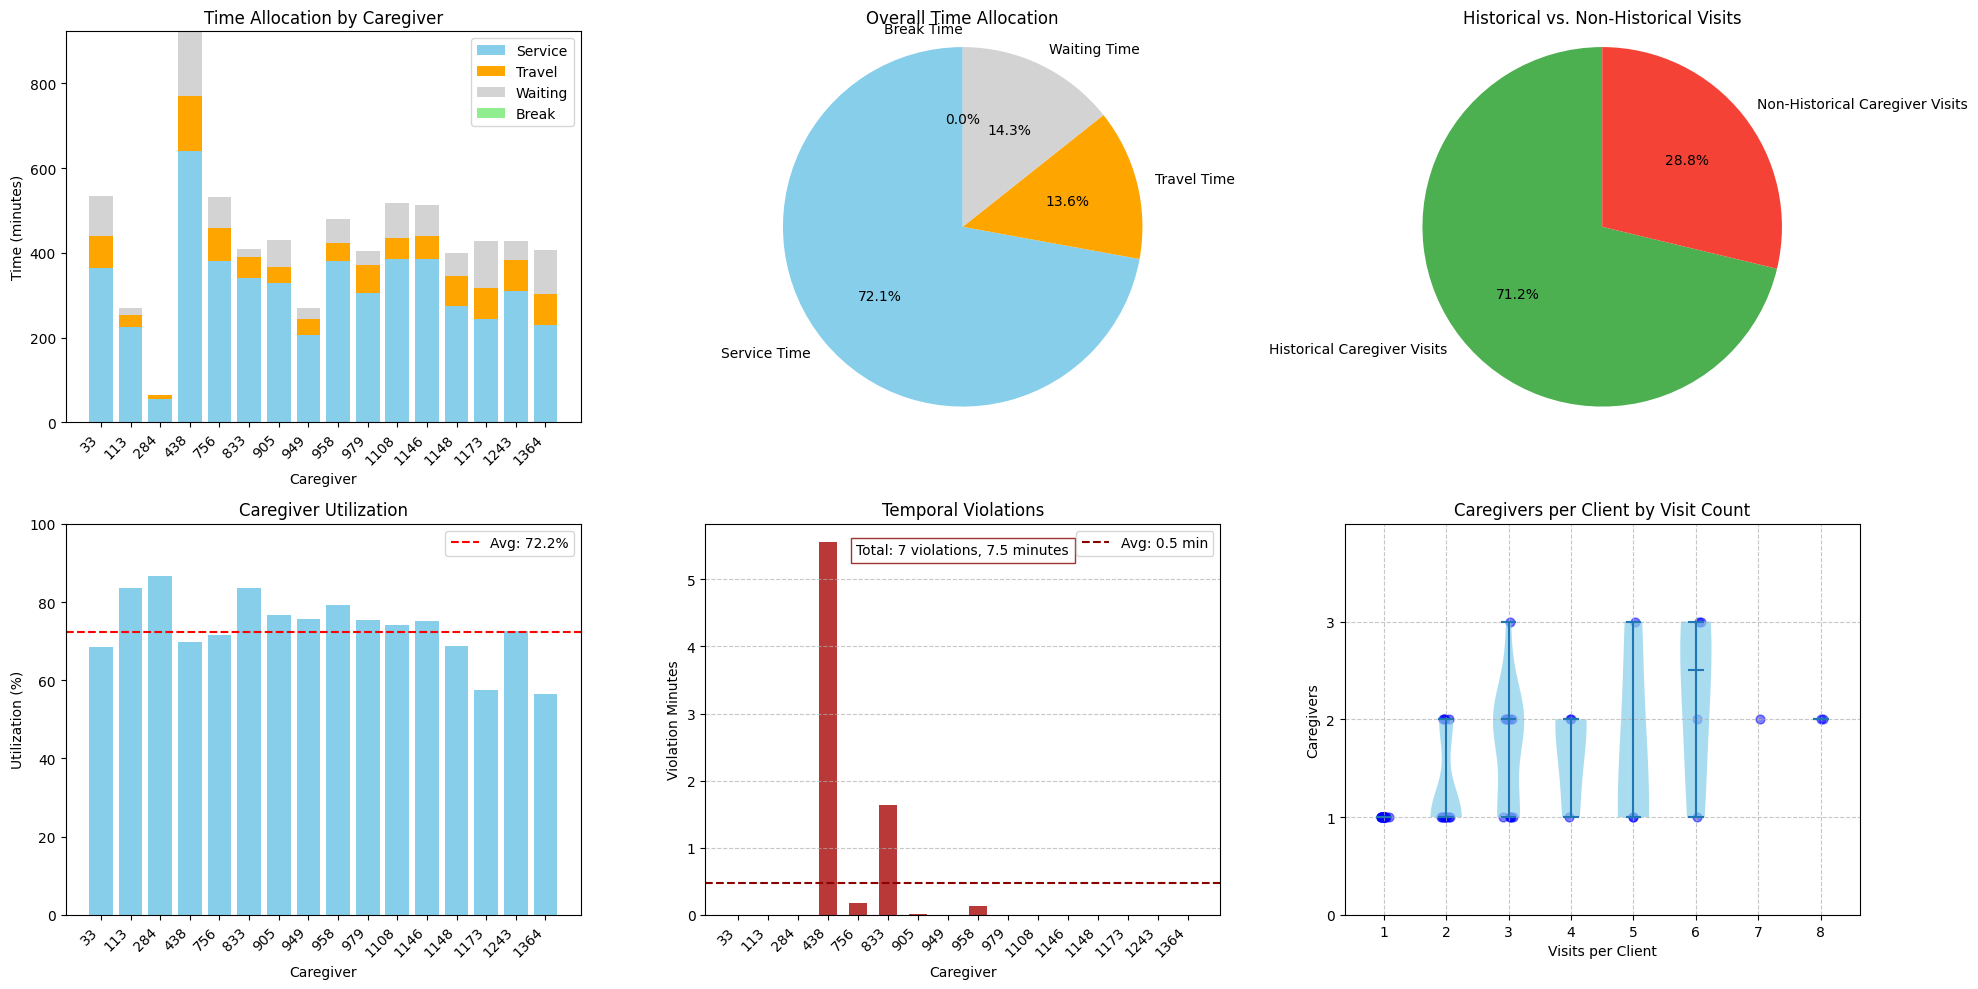

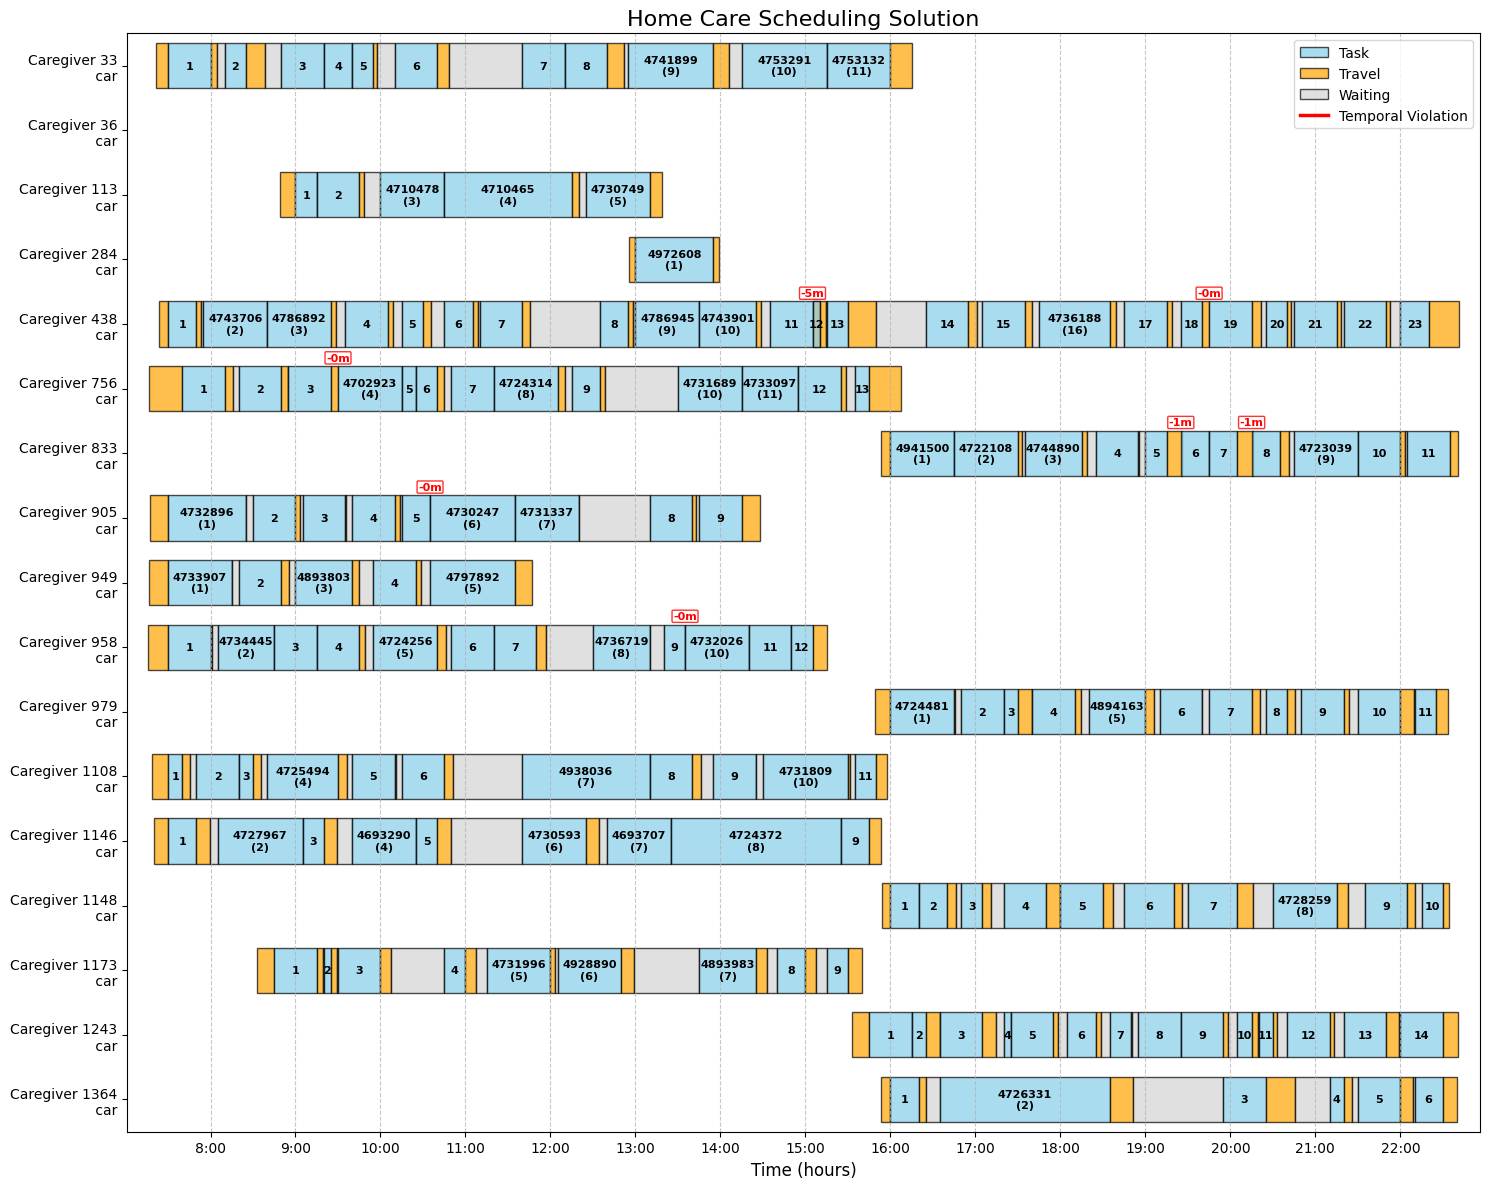

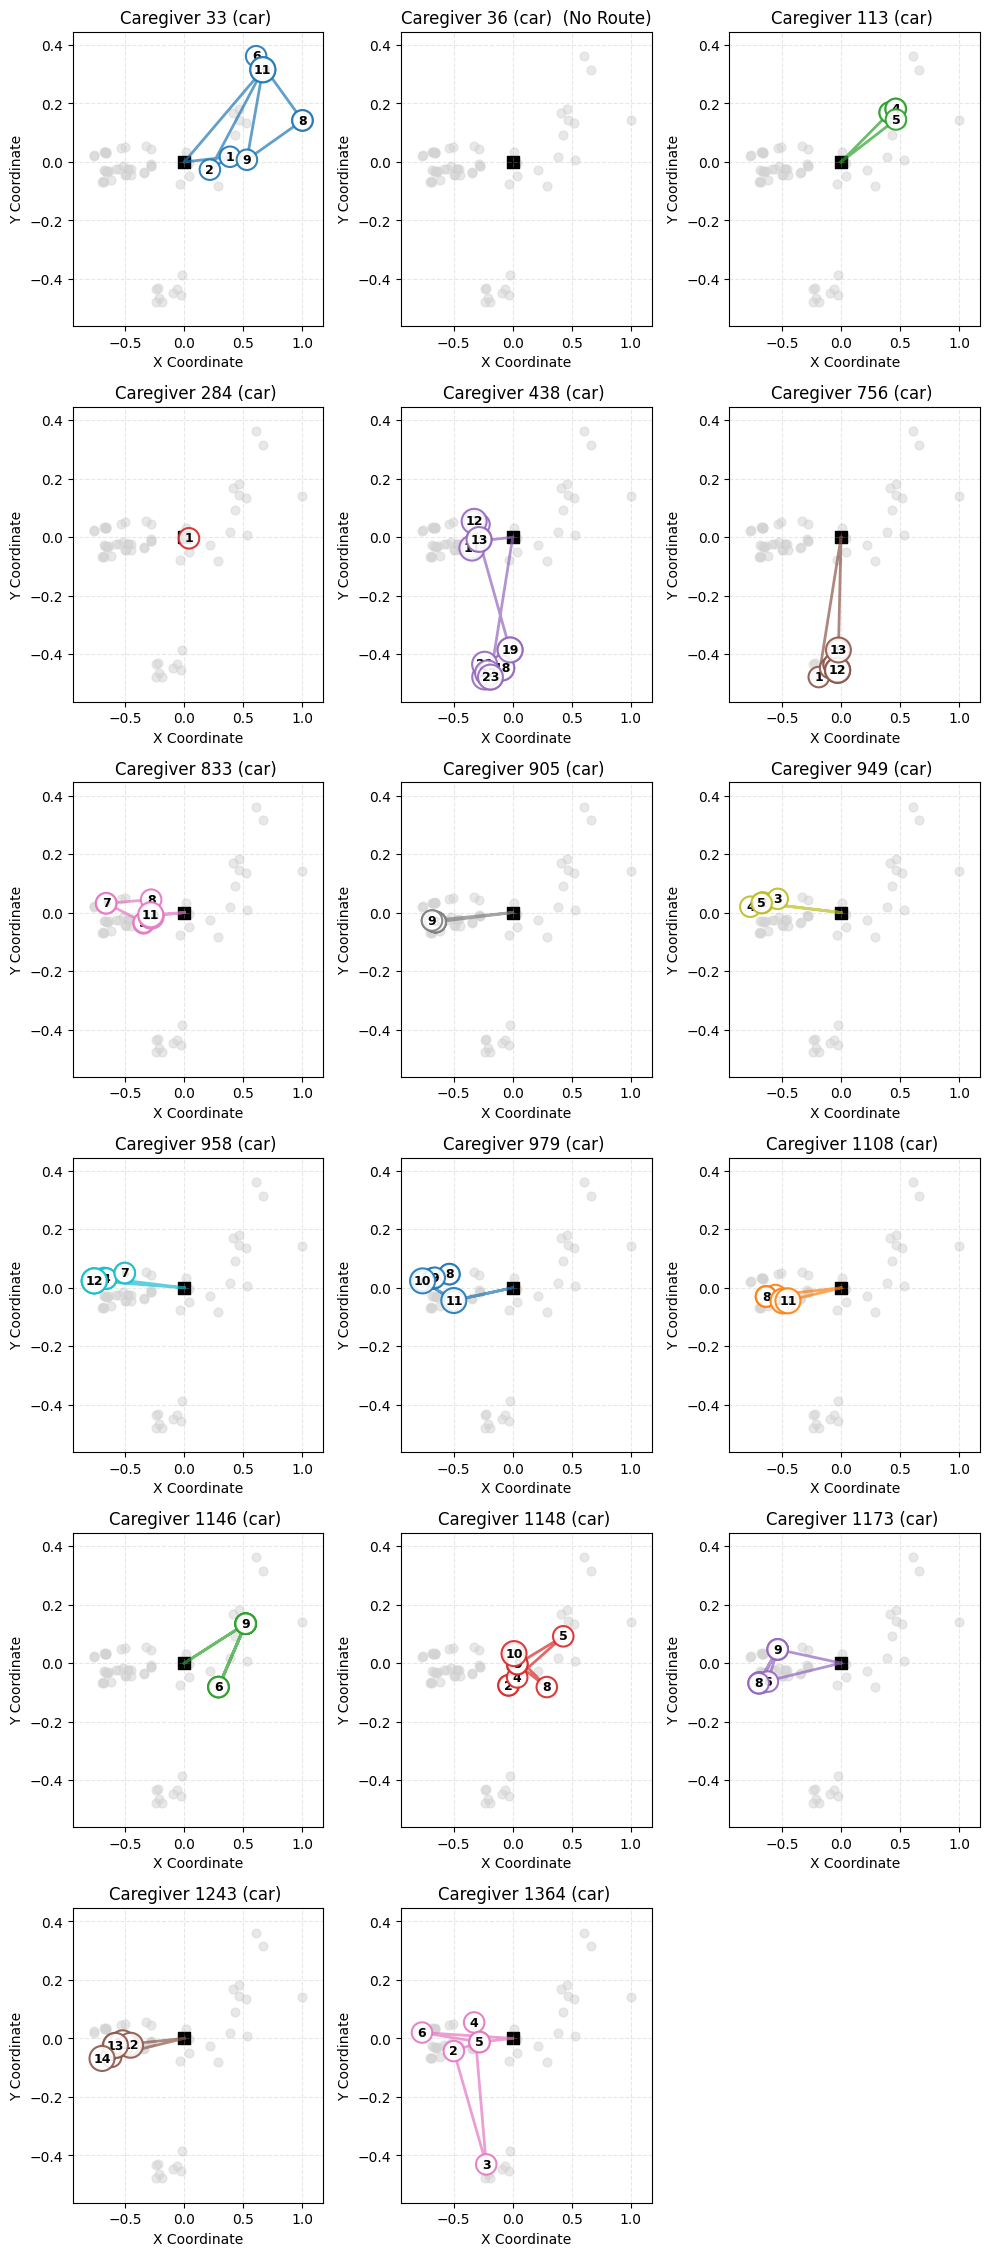

In [16]:
from utils.solution_storage import create_model_from_real_data

real_data_model = create_model_from_real_data(model.caregivers, model.tasks, model.clients, model.drive_time_matrix, model.walk_time_matrix, model.bicycle_time_matrix, model.continuity)

# display_metrics_summary(real_data_model)
visualize_metrics(real_data_model, display_mode='dashboard')
visualize_schedule(real_data_model)
visualize_routes(real_data_model, caregiver_ids=None, subplot_mode=True)
